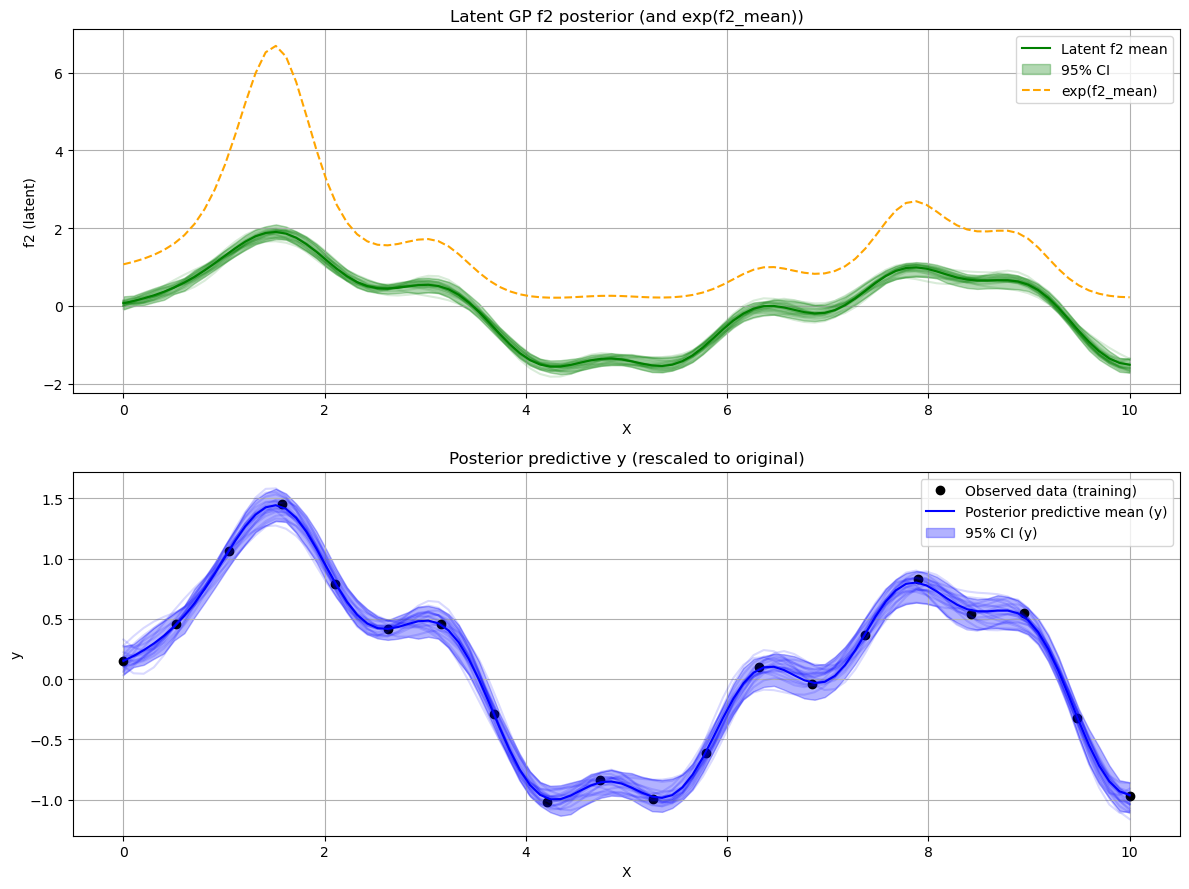

In [11]:
# Gaussian Process Toy Example: Latent f2 and Posterior Predictive y
# --------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# -------------------------
# 1. Generate toy data
# -------------------------
np.random.seed(42)

X = np.linspace(0, 10, 20).reshape(-1, 1)   # training inputs
y = np.sin(X).ravel() + 0.3 * np.random.randn(X.shape[0])  # noisy observations

# Standardize y for predictive rescaling later
y_train_mean = y.mean()
y_train_std = y.std()
y_std = (y - y_train_mean) / y_train_std

# -------------------------
# 2. Fit a Gaussian Process
# -------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0.1**2, normalize_y=True)
gp.fit(X, y_std)

# -------------------------
# 3. Predict on new points
# -------------------------
X_star = np.linspace(0, 10, 100).reshape(-1, 1)  # prediction inputs
y_mean_std, y_cov = gp.predict(X_star, return_cov=True)
y_std_samples = np.random.multivariate_normal(y_mean_std, y_cov, size=50)

# Rescale to original y
y_mean = y_mean_std * y_train_std + y_train_mean
y_post = y_std_samples * y_train_std + y_train_mean
y_lo, y_hi = np.percentile(y_post, [2.5, 97.5], axis=0)

# -------------------------
# 4. Latent f2 approximation
# (just for demonstration, using same GP as latent)
# -------------------------
f2_mean = y_mean_std
f2_post = y_std_samples
f2_lo, f2_hi = np.percentile(f2_post, [2.5, 97.5], axis=0)
exp_f2_mean = np.exp(f2_mean)

# -------------------------
# 5. Plot latent f2 and posterior predictive y
# -------------------------
X_pred_flat = X_star.flatten()
n_samples_to_plot = min(20, y_post.shape[0], f2_post.shape[0])

plt.figure(figsize=(12, 9))

# Top: latent f2
ax1 = plt.subplot(2, 1, 1)
ax1.plot(X_pred_flat, f2_mean, color='green', label="Latent f2 mean")
ax1.fill_between(X_pred_flat, f2_lo, f2_hi, color='green', alpha=0.3, label="95% CI")
for i in np.random.choice(f2_post.shape[0], n_samples_to_plot, replace=False):
    ax1.plot(X_pred_flat, f2_post[i], color='green', alpha=0.15)
ax1.plot(X_pred_flat, exp_f2_mean, color='orange', linestyle='--', label="exp(f2_mean)")
ax1.set_xlabel("X")
ax1.set_ylabel("f2 (latent)")
ax1.set_title("Latent GP f2 posterior (and exp(f2_mean))")
ax1.legend()
ax1.grid(True)

# Bottom: posterior predictive y
ax2 = plt.subplot(2, 1, 2)
ax2.plot(X.flatten(), y, 'o', color='black', label="Observed data (training)")
ax2.plot(X_pred_flat, y_mean, color='blue', label="Posterior predictive mean (y)")
ax2.fill_between(X_pred_flat, y_lo, y_hi, color='blue', alpha=0.3, label="95% CI (y)")
for i in np.random.choice(y_post.shape[0], n_samples_to_plot, replace=False):
    ax2.plot(X_pred_flat, y_post[i], color='blue', alpha=0.15)
ax2.set_xlabel("X")
ax2.set_ylabel("y")
ax2.set_title("Posterior predictive y (rescaled to original)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


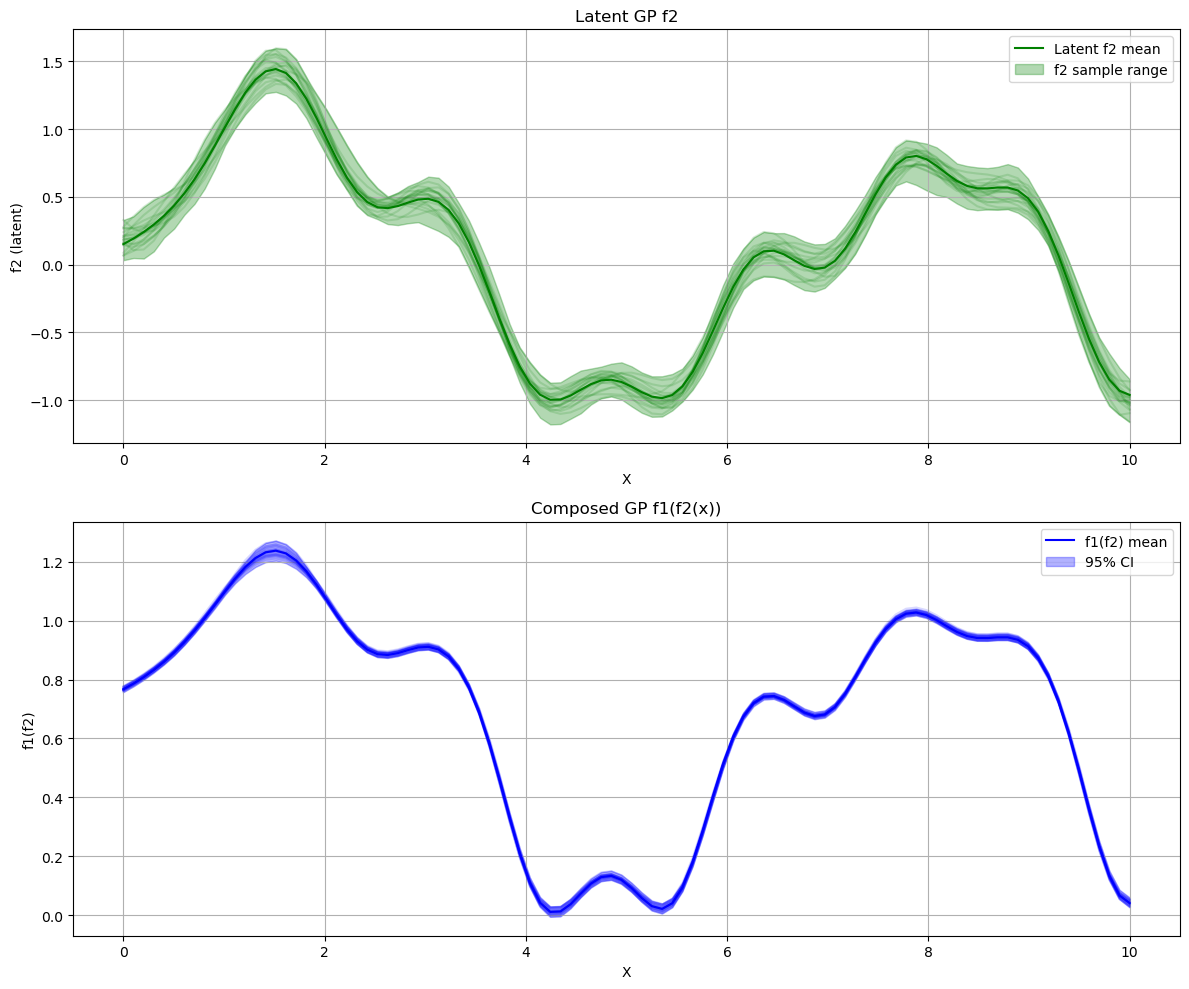

In [12]:
# Gaussian Process Composition: f1(f2(x))
# --------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(42)

# -------------------------
# 1. Generate toy data
# -------------------------
X = np.linspace(0, 10, 20).reshape(-1, 1)
y = np.sin(X).ravel() + 0.3 * np.random.randn(X.shape[0])  # observed data

# Standardize y for later rescaling
y_train_mean = y.mean()
y_train_std = y.std()
y_std = (y - y_train_mean) / y_train_std

# -------------------------
# 2. Fit first GP (f2)
# -------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_f2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0.1**2, normalize_y=True)
gp_f2.fit(X, y_std)

X_star = np.linspace(0, 10, 100).reshape(-1, 1)
f2_mean_std, f2_cov = gp_f2.predict(X_star, return_cov=True)
f2_samples_std = np.random.multivariate_normal(f2_mean_std, f2_cov, size=50)

# Rescale f2 to original y-scale
f2_mean = f2_mean_std * y_train_std + y_train_mean
f2_samples = f2_samples_std * y_train_std + y_train_mean

# -------------------------
# 3. Compose second GP (f1(f2))
# For simplicity, f1 will also be a GP fit to f2_samples mean
# -------------------------
# We'll generate noisy targets for f1 for demonstration
f1_targets = np.log(f2_mean - f2_mean.min() + 1)  # some nonlinear transformation
gp_f1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0.1**2, normalize_y=True)
gp_f1.fit(f2_mean.reshape(-1,1), f1_targets)

# Predict f1(f2(x))
f1_mean, f1_cov = gp_f1.predict(f2_mean.reshape(-1,1), return_cov=True)
f1_samples = np.random.multivariate_normal(f1_mean, f1_cov, size=50)
f1_lo, f1_hi = np.percentile(f1_samples, [2.5, 97.5], axis=0)

# -------------------------
# 4. Plotting
# -------------------------
n_samples_to_plot = min(20, f2_samples.shape[0], f1_samples.shape[0])
X_pred_flat = X_star.flatten()

plt.figure(figsize=(12, 10))

# Top: latent f2
ax1 = plt.subplot(2,1,1)
ax1.plot(X_pred_flat, f2_mean, color='green', label="Latent f2 mean")
ax1.fill_between(X_pred_flat, f2_samples.min(axis=0), f2_samples.max(axis=0), color='green', alpha=0.3, label="f2 sample range")
for i in np.random.choice(f2_samples.shape[0], n_samples_to_plot, replace=False):
    ax1.plot(X_pred_flat, f2_samples[i], color='green', alpha=0.15)
ax1.set_xlabel("X")
ax1.set_ylabel("f2 (latent)")
ax1.set_title("Latent GP f2")
ax1.legend()
ax1.grid(True)

# Bottom: f1(f2(x))
ax2 = plt.subplot(2,1,2)
ax2.plot(X_pred_flat, f1_mean, color='blue', label="f1(f2) mean")
ax2.fill_between(X_pred_flat, f1_lo, f1_hi, color='blue', alpha=0.3, label="95% CI")
for i in np.random.choice(f1_samples.shape[0], n_samples_to_plot, replace=False):
    ax2.plot(X_pred_flat, f1_samples[i], color='blue', alpha=0.15)
ax2.set_xlabel("X")
ax2.set_ylabel("f1(f2)")
ax2.set_title("Composed GP f1(f2(x))")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
